In [1]:
import openslide
import math
import sys, os
import cv2
import tables
import random

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk # (modified with elastix)
import pandas as pd
import seaborn as sns

from collections import Counter 
from skimage.transform import resize
from tifffile import imread, imwrite
from ipywidgets import interact, fixed
from skimage import morphology, filters
from PIL import Image

from sklearn.model_selection import train_test_split

from misc.utils import *

# Global Variables

In [2]:
# Path of IF and HE image files 

IF_path = 'Experiment/IF40X/HE2mIF_MELANOME_3/Scan1/HE2mIF_MELANOME_3_Scan1.qptiff'
HE_path = 'Experiment/HE40X/MELANOMA_AA3_40X/Scan1/MELANOMA_AA3_40X_Scan1.qptiff'


# Retrieve Cells

## Cells Locations

In [4]:
# Load images using OpenSlide
IF_open = openslide.OpenSlide(IF_path)
HE_open = openslide.OpenSlide(HE_path)

# Gets the origin of the IF image
OR_x = float(IF_open.properties['tiff.XPosition'])*10000
OR_y = float(IF_open.properties['tiff.YPosition'])*10000

# Gets the resolution of the IF image
x_resolution = float(IF_open.properties['tiff.XResolution'])*1e-4
y_resolution = float(IF_open.properties['tiff.YResolution'])*1e-4


dimensions = IF_open.dimensions

In [5]:
# Reads the cell locations from inForm analysis software
cells_locations = pd.read_csv('Experiment/Mel3CellSegData_merge_cell_seg_data.txt', sep='\t', usecols=['Cell X Position', 'Cell Y Position', 'Phenotype'])

# Removes the offset (origin)
cells_locations['cell_x_position'] = cells_locations['Cell X Position'] - OR_x
cells_locations['cell_y_position'] = cells_locations['Cell Y Position'] - OR_y

# Converts the position from cm to pixel position
cells_locations['cell_xpixel_position'] = cells_locations.cell_x_position.apply(lambda x: x*x_resolution).values
cells_locations['cell_ypixel_position'] = cells_locations.cell_y_position.apply(lambda x: x*y_resolution).values

In [6]:
cells_locations

,Phenotype,Cell X Position,Cell Y Position,cell_x_position,cell_y_position,cell_xpixel_position,cell_ypixel_position
0,SOX10p,9670.1,27024.3,2889.464286,1533.596406,11561.106917,6136.110456
1,SOX10p,9674.6,27025.5,2893.964286,1534.796406,11579.111979,6140.911805
2,SOX10p,9774.8,27028.3,2994.164286,1537.596406,11980.024673,6152.114955
3,SOX10p,9782.0,27030.8,3001.364286,1540.096406,12008.832771,6162.117766
4,SOX10p,9760.5,27032.3,2979.864286,1541.596406,11922.808590,6168.119453
...,...,...,...,...,...,...,...
1457078,DAPIp,16434.2,47799.7,9653.564286,22308.996406,38625.114482,89261.076491
1457079,SOX10p,16427.7,47801.7,9647.064286,22310.996406,38599.107171,89269.078740
1457080,CD20p,16462.2,47801.9,9681.564286,22311.196406,38737.145973,89269.878965
1457081,SOX10p,16399.7,47802.9,9619.064286,22312.196406,38487.075680,89273.880090


## Mask Generation

['CD3p', 'SOX10p', 'CD56p', 'CD11Cp', 'CD68p', 'CD20p']

In [7]:
# Creates an empty image of the size of the original IF image
dots = sitk.Image(dimensions[0], dimensions[1], sitk.sitkUInt8)

phenotype = 'CD3p'

for x,y in zip(cells_locations[cells_locations['Phenotype']==phenotype].cell_xpixel_position.values, cells_locations[cells_locations['Phenotype']==phenotype].cell_ypixel_position.values):
    
    
    # Draws points at cell locations of the empty image for a specific phenotype
    draw_point(dots, x=int(x), y=int(y), size=3)


# mIF to H&E Image Registration 

## Load Image & ROI Selection

In [8]:
# Choose ROI size (Better to take a square)
size=(12000,12000)

# Manually select the corresponding origin of both image
IF_origin = (9270,49150)
HE_origin = (12000,50000)


In [9]:
# Read region at the specified origin with the specified size
IF_open = np.asarray(IF_open.read_region(IF_origin, 0, size))[:,:,0]

In [10]:
HE_open = np.asarray(HE_open.read_region(HE_origin, 0, size))[:,:,0]

In [11]:
IF_open.shape

(12000, 12000)

In [12]:
dots.GetSize()

(55680, 93600)

In [13]:
# Crops the dots image exactly like the IF image

dots = dots[IF_origin[0]:IF_origin[0]+size[0],IF_origin[1]:IF_origin[1]+size[1]]
dots.SetOrigin((0,0))

In [14]:
dots.GetSize()

(12000, 12000)

In [15]:
# Converts the image to ITK format

IF_open = sitk.GetImageFromArray(IF_open)
HE_open = sitk.GetImageFromArray(HE_open)

## Image Pre-Registration (Elastix)

In [16]:
# Downscale the images
HE_resize_ITK, IF_resize_ITK, x_scaling_factor_IF, y_scaling_factor_IF  = downscale_pair_image(sitk.GetArrayFromImage(HE_open),sitk.GetArrayFromImage(IF_open))

# initialize the registration
elastixImageFilter = sitk.ElastixImageFilter()

# sets the fixed image
elastixImageFilter.SetFixedImage(sitk.Normalize(HE_resize_ITK))

# set the moving image
elastixImageFilter.SetMovingImage(sitk.Normalize(IF_resize_ITK))

parameterMapVector = sitk.VectorOfParameterMap()

# add translation and affine transforms to the paramter map
parameterMapVector.append(sitk.GetDefaultParameterMap("translation"))
parameterMapVector.append(sitk.GetDefaultParameterMap("affine")) # --> rigid to try 

elastixImageFilter.SetParameterMap(parameterMapVector)

print(bcolors.OKBLUE + "Registering resized image" + bcolors.ENDC)
elastixImageFilter.Execute()
print(bcolors.OKGREEN + "done" + bcolors.ENDC)

Registering resized image
done


In [17]:
print("Rescaling original IF Image")

# gets the downscaled parameter map that needs to be rescaled
parameterMap = elastixImageFilter.GetTransformParameterMap()

# gets translation parameters
transform_parameters_translation = parameterMap[0]["TransformParameters"]
size_parameters = parameterMap[0]["Size"]

# gets affine parameters (affine)
transform_parameters_rotation = parameterMap[1]["CenterOfRotationPoint"]

# rescaling the parameters
rescaled_parameters_translation = (str(float(transform_parameters_translation[0])*y_scaling_factor_IF), str(float(transform_parameters_translation[1])*x_scaling_factor_IF))
rescaled_size = (str(int(float(size_parameters[0])*y_scaling_factor_IF)), str((int(float(size_parameters[1])*x_scaling_factor_IF))))

rescaled_parameters_rotation = (str(float(transform_parameters_rotation[0])*y_scaling_factor_IF), str(float(transform_parameters_rotation[1])*x_scaling_factor_IF))

# sets the new parameters
parameterMap[0]["TransformParameters"] = rescaled_parameters_translation
parameterMap[0]["Size"] = rescaled_size

parameterMap[1]["CenterOfRotationPoint"] = rescaled_parameters_rotation
parameterMap[1]["Size"] = rescaled_size

transformix = sitk.TransformixImageFilter()

# sets the new rescaled parameters 
transformix.SetTransformParameterMap(parameterMap)

# transforming the original IF image (pre-registration)
transformix.SetMovingImage(IF_open)
transformix.Execute()

IF_open = transformix.GetResultImage()

Rescaling original IF Image


In [18]:
# Applying the same pre-registration to the dots

print("Rescaling original dots Image")

transformix.SetMovingImage(dots)
transformix.Execute()

dots = transformix.GetResultImage()


Rescaling original dots Image


## WSI Registration 

In [19]:
tile_size_x = 2000
tile_size_y = 2000

# creating pairs of 2000 x 2000 pixel tiles

IF_open = tiling(IF_open, tile_size_x, tile_size_y)
HE_open = tiling(sitk.Cast(HE_open,sitk.sitkFloat32), tile_size_x, tile_size_y)


Performing multichannel tiling...
x window size: 2000
ywindow size: 2000
number of tiles along x axis: 6
number of tiles along y axis: 6
done
Performing multichannel tiling...
x window size: 2000
ywindow size: 2000
number of tiles along x axis: 6
number of tiles along y axis: 6
done


In [20]:
# tiling the dot image the same way

dots = tiling(dots, tile_size_x, tile_size_y)


Performing multichannel tiling...
x window size: 2000
ywindow size: 2000
number of tiles along x axis: 6
number of tiles along y axis: 6
done


In [22]:
index = 14
interact(display_images_with_alpha, alpha=(0,1,0.2), fixed = fixed(sitk.Cast(HE_open[index][0:500,0:500],sitk.sitkFloat32)), moving = fixed(sitk.Cast(IF_open[index][0:500,0:500],sitk.sitkFloat32)))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.2), Output()), _dom_classes=…

<function __main__.display_images_with_alpha(alpha, fixed, moving)>

In [27]:
# Set regis to True if you want the registered images. 
param = translate_arrays(HE_open, IF_open, method = ['rigid', 'affine', 'bspline'], weight = 500, regis = False, num_iter=500, number_resolution = 5)

performing whole slide image registration...
registering frame 1/36
registering frame 2/36
registering frame 3/36
registering frame 4/36
registering frame 5/36
registering frame 6/36
registering frame 7/36
registering frame 8/36
registering frame 9/36
registering frame 10/36
registering frame 11/36
registering frame 12/36
registering frame 13/36
registering frame 14/36
registering frame 15/36
registering frame 16/36
registering frame 17/36
registering frame 18/36
registering frame 19/36
registering frame 20/36
registering frame 21/36
registering frame 22/36
registering frame 23/36
registering frame 24/36
registering frame 25/36
registering frame 26/36
registering frame 27/36
registering frame 28/36
registering frame 29/36
registering frame 30/36
registering frame 31/36
registering frame 32/36
registering frame 33/36
registering frame 34/36
registering frame 35/36
registering frame 36/36
done


In [24]:
interact(display_images_with_alpha, alpha=(0,1,0.2), fixed = fixed(sitk.Cast(HE_open[index][0:500,0:500],sitk.sitkFloat32)), moving = fixed(sitk.Cast(regis[0][0:500,0:500],sitk.sitkFloat32)))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.2), Output()), _dom_classes=…

<function __main__.display_images_with_alpha(alpha, fixed, moving)>

In [28]:
# transform the dots positions with the saved parameters
dots_registered = transform_array(dots, param)


In [26]:
interact(display_images_with_alpha, alpha=(0,1,0.2), fixed = fixed(sitk.Cast(HE_open[index][0:500,0:500],sitk.sitkFloat32)), moving = fixed(sitk.Cast(dots_registered[0][0:500,0:500],sitk.sitkFloat32)))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.2), Output()), _dom_classes=…

<function __main__.display_images_with_alpha(alpha, fixed, moving)>

In [29]:
# reconstruct back the image
dots_registered = reconstruct_image(size=size, frames=dots_registered)


Number of x intervals: 6
Number of y intervals: 6


In [31]:
dots_registered.shape

(12000, 12000)

## Transforming new positions

In [32]:
# Get array format to apply image processing techniques
dots_registered = sitk.GetArrayFromImage(sitk.Cast(sitk.GetImageFromArray(dots_registered),sitk.sitkUInt8))


# Retrieving new cell positions

## Dots Filtering to single pixel

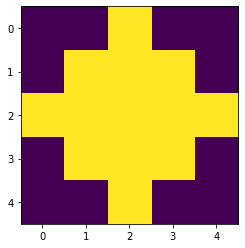

In [33]:
selem = morphology.disk(2)
plt.imshow(selem)
plt.savefig('disk_2.jpg')


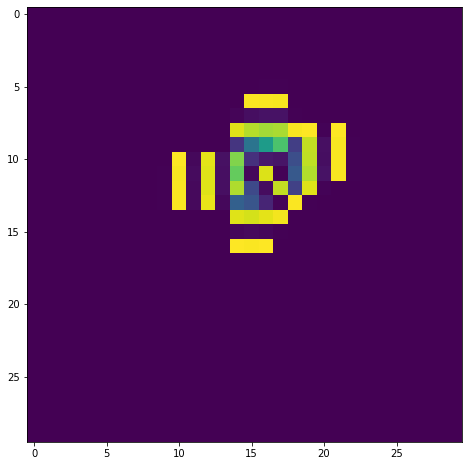

In [34]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(dots_registered[6050:6080, 6080:6110])

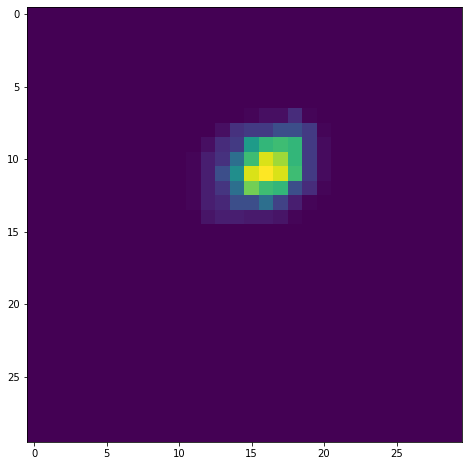

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
selem = morphology.disk(4)
res=filters.median(dots_registered,selem)
ax.imshow(res[6050:6080, 6080:6110])


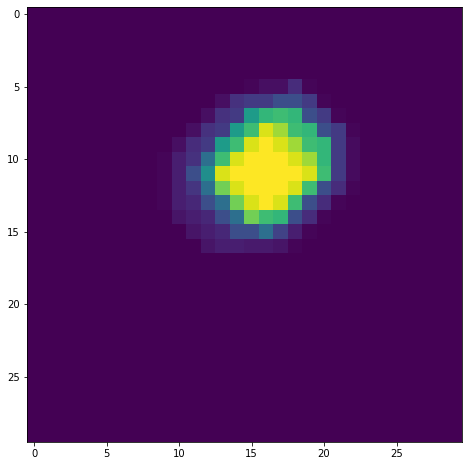

In [36]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
selem = morphology.disk(2)
res_2=morphology.dilation(res, selem)
ax.imshow(res_2[6050:6080, 6080:6110])


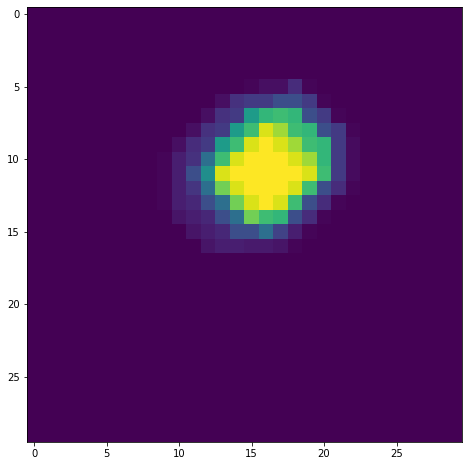

In [37]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
selem = morphology.disk(2)
res_3=morphology.opening(res_2, selem)
ax.imshow(res_3[6050:6080, 6080:6110])


In [38]:
ret, thresh = cv2.threshold(res_3,25,255,0)


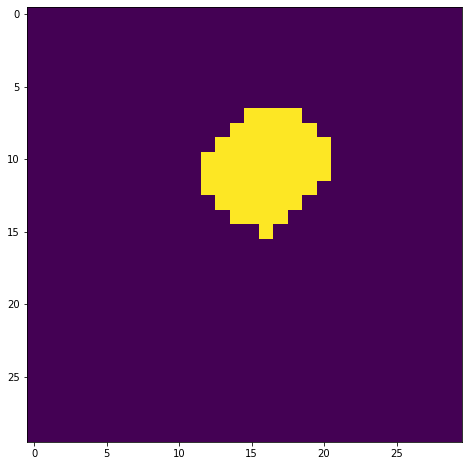

In [39]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(thresh[6050:6080, 6080:6110])


In [35]:
# sets a morphological shape (disk of radius 4)
selem = morphology.disk(4)
res=filters.median(dots_registered,selem)

# sets a morphological shape (disk of radius 2)
selem = morphology.disk(2)
res=morphology.dilation(res, selem)

# sets a morphological shape (disk of radius 2)
selem = morphology.disk(2)
res=morphology.opening(res, selem)


In [36]:
# Creates an empty pandas dataframe
HE_cells_locations = pd.DataFrame(columns=['x_coordinate', 'y_coordinate', 'type'])
HE_cells_locations.head()

,x_coordinate,y_coordinate,type


In [37]:
# Binaries the image
ret, thresh = cv2.threshold(res,5,255,0)

# Gets the contours (shapes)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Extract positions
for index, c in enumerate(contours): 
    M = cv2.moments(c)
    
    y = int(M["m10"]/M["m00"]) + 0
    x = int(M["m01"]/M["m00"]) + 0
    
    HE_cells_locations = HE_cells_locations.append({'x_coordinate':x, 'y_coordinate':y, 'type':phenotype}, ignore_index=True)
    
del dots, res, thresh

In [38]:
HE_cells_locations.head()

,x_coordinate,y_coordinate,type
0,11930,7521,SOX10p
1,11923,6651,SOX10p
2,11916,7573,SOX10p
3,11908,8390,SOX10p
4,11908,6735,SOX10p


In [83]:
HE_cells_locations.to_csv('3_MEL3_HE_cells_locations_withoffset_5_29000_36000.txt', header=None, index = None, sep='\t', mode='a')

In [84]:
HE_cells_locations['x_coordinate'] = HE_cells_locations['x_coordinate'] + HE_origin[1]
HE_cells_locations['y_coordinate'] = HE_cells_locations['y_coordinate'] + HE_origin[0] 

HE_cells_locations.to_csv('3_MEL3_HE_cells_locations_NoOffset_5_29000_36000.txt', header=None, index = None, sep='\t', mode='a')

# Visualization 

In [40]:
HE_open_visu = openslide.OpenSlide(HE_path)
HE_open_visu = np.asarray(HE_open_visu.read_region(HE_origin,0,size)).copy()
HE_open_visu.setflags(write=1)


In [41]:
def draw_circle(image, x, y, pixel_value = (0,255,0), radius = 10, thickness = 2):
    
    cv2.circle(image, (x,y), radius, pixel_value, thickness)
    

In [43]:
df_test = HE_cells_locations.copy()

for x,y in zip(df_test[df_test['type']=='CD3p'].x_coordinate.values, df_test[df_test['type']=='CD3p'].y_coordinate.values):
    
    draw_circle(HE_open_visu, y, x, pixel_value = (0,255,0), radius = 15, thickness = 5)
    
for x,y in zip(df_test[df_test['type']=='SOX10p'].x_coordinate.values, df_test[df_test['type']=='SOX10p'].y_coordinate.values):
    
    draw_circle(HE_open_visu, y, x, pixel_value = (255,0,0), radius = 15, thickness = 5)
    
for x,y in zip(df_test[df_test['type']=='CD11Cp'].x_coordinate.values, df_test[df_test['type']=='CD11Cp'].y_coordinate.values):
    
    draw_circle(HE_open_visu, y, x, pixel_value = (0,0,255), radius = 15, thickness = 5)

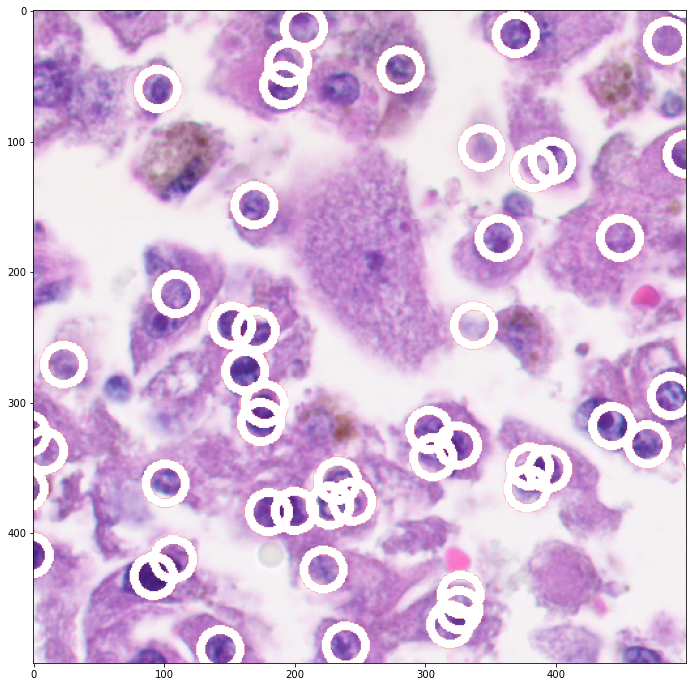

In [44]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(HE_open_visu[6000:6500,6000:6500])
